In [1]:
import setproctitle

setproctitle.setproctitle("andrey_validation")

In [2]:
import gc
import os
import sys
import time

import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
from tqdm.notebook import tqdm

tqdm.pandas()

In [3]:
samples_catboost = {
    k: pd.read_parquet(f"/home/asciishell/s3/jupyter.asciishell.ru/data_{k}.parquet") for k in ["train", "oos", "oot"]
}
samples_woe = {
    k: pd.read_parquet(f"/home/asciishell/s3/jupyter.asciishell.ru/data_{k}_with_score_WoE.parquet")
    for k in ["train", "oos", "oot"]
}

In [4]:
features = [
    "inq_fi",
    "all_util",
    "home_ownership",
    "log_annual_inc",
    "annual_inc",
    "num_rev_tl_bal_gt_0",
    "mort_acc",
    "funded_amnt_inv",
    "emp_title",
    "bc_open_to_buy",
    "debt_load",
    "fico_range_low",
    "fico_range_high",
]

cat_features = [
    "emp_title",
    "home_ownership",
    "verification_status",
    "purpose",
    "zip_code",
    "addr_state",
    "initial_list_status",
    "application_type",
    "verification_status_joint",
    "disbursement_method",
]
cat_features = sorted(set(cat_features) & set(features))
params = {
    "iterations": 400,
    "depth": 6,
    "l2_leaf_reg": 24.337217538245532,
    "learning_rate": 0.14119449759028455,
    "random_strength": 1.284731588293853,
    "rsm": 0.5363370106196876,
    "grow_policy": "SymmetricTree",
    "od_wait": 50,
    "eval_metric": "AUC",
    "logging_level": "Silent",
}

In [5]:
clf = catboost.CatBoostClassifier(**params)
clf.load_model("catboost.cb");

In [6]:
dfs_catboost = {k: v[v["target"] != -1] for k, v in samples_catboost.items()}  # [features + ["target"]]
dfs_woe = {k: v[v["target"] != -1] for k, v in samples_woe.items()}

pools = {
    k: catboost.Pool(v[v["target"] != -1][features], v[v["target"] != -1]["target"], cat_features=cat_features)
    for k, v in samples_catboost.items()
}

for key in pools:
    dfs_catboost[key]["score"] = clf.predict_proba(pools[key])[:, 1]

/tmp/ipykernel_1621/1972046527.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_catboost[key]["score"] = clf.predict_proba(pools[key])[:, 1]
/tmp/ipykernel_1621/1972046527.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_catboost[key]["score"] = clf.predict_proba(pools[key])[:, 1]
/tmp/ipykernel_1621/1972046527.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [7]:
NUM_RATINGS = 12

kbd = KBinsDiscretizer(
    n_bins=NUM_RATINGS,
    encode="ordinal",
    strategy="kmeans",
    # strategy='quantile',
    # strategy='uniform',
)
kbd_woe = KBinsDiscretizer(
    n_bins=NUM_RATINGS,
    encode="ordinal",
    strategy="kmeans",
    # strategy='quantile',
    # strategy='uniform',
)
kbd.fit(dfs_catboost["train"]["score"].to_numpy().reshape(-1, 1))
kbd_woe.fit(dfs_woe["train"]["score"].to_numpy().reshape(-1, 1))

for key in dfs_catboost:
    dfs_catboost[key]["rating"] = kbd.transform(dfs_catboost[key]["score"].to_numpy().reshape(-1, 1)).flatten()
for key in dfs_woe:
    dfs_woe[key]["rating"] = kbd_woe.transform(dfs_woe[key]["score"].to_numpy().reshape(-1, 1)).flatten()

/tmp/ipykernel_1621/2099467229.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_catboost[key]["rating"] = kbd.transform(dfs_catboost[key]["score"].to_numpy().reshape(-1, 1)).flatten()
/tmp/ipykernel_1621/2099467229.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_catboost[key]["rating"] = kbd.transform(dfs_catboost[key]["score"].to_numpy().reshape(-1, 1)).flatten()
/tmp/ipykernel_1621/2099467229.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [8]:
catboost_ratings_info = {}
woe_ratings_info = {}
for key in dfs_catboost:
    catboost_ratings_info[key] = (
        dfs_catboost[key].groupby("rating").agg({"target": [np.mean, len, np.sum], "score": [np.min, np.max]})
    )
    woe_ratings_info[key] = (
        dfs_woe[key].groupby("rating").agg({"target": [np.mean, len, np.sum], "score": [np.min, np.max]})
    )

In [9]:
catboost_ratings_info["train"]

target                    score          
            mean     len    sum      amin      amax
rating                                             
0.0     0.047416   53336   2529  0.005430  0.076036
1.0     0.091446   94449   8637  0.076037  0.116390
2.0     0.128084  111419  14271  0.116391  0.151817
3.0     0.163886  111956  18348  0.151817  0.186075
4.0     0.198726   99383  19750  0.186076  0.220835
5.0     0.237170   81861  19415  0.220835  0.257117
6.0     0.279455   63910  17860  0.257117  0.295875
7.0     0.325830   48022  15647  0.295879  0.338665
8.0     0.385611   33845  13051  0.338667  0.387533
9.0     0.444025   22501   9991  0.387535  0.445215
10.0    0.502156   12757   6406  0.445223  0.520802
11.0    0.601856    4526   2724  0.520819  0.806789

In [10]:
woe_ratings_info["train"]

target                    score          
            mean     len    sum      amin      amax
rating                                             
0.0     0.060595   46555   2821  0.033008  0.089065
1.0     0.105886   75506   7995  0.089073  0.123600
2.0     0.136083   96735  13164  0.123603  0.155056
3.0     0.165697  109103  18078  0.155062  0.185433
4.0     0.198090  108380  21469  0.185435  0.215616
5.0     0.231255   95371  22055  0.215618  0.245919
6.0     0.265188   77892  20656  0.245925  0.276746
7.0     0.300988   60617  18245  0.276750  0.309375
8.0     0.338439   41845  14162  0.309404  0.344857
9.0     0.373715   19753   7382  0.344875  0.382662
10.0    0.412481    5336   2201  0.382720  0.422313
11.0    0.459862     872    401  0.422525  0.488898

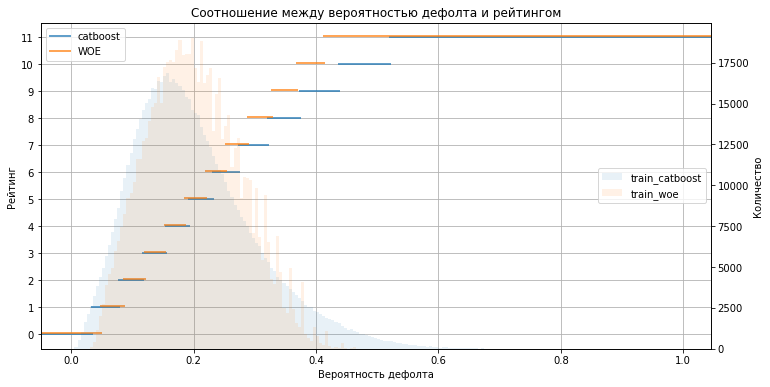

In [11]:
# NUM_RATINGS

# plt.scatter(catboost_ratings_info["train"]["score", "amin"], catboost_ratings_info["train"].index)
# plt.scatter(catboost_ratings_info["train"]["score", "amax"], catboost_ratings_info["train"].index)
fig, ax = plt.subplots(figsize=(12, 6))
for i, a in catboost_ratings_info["train"].iterrows():
    if i == 0:
        xmin = 0
    else:
        xmin = a["score", "amin"]
    if i == NUM_RATINGS - 1:
        xmax = 1
    else:
        xmax = a["score", "amax"]
    line1 = ax.axhline(
        y=i,
        xmin=xmin,
        xmax=xmax,
        # color='b',
        alpha=0.7,
        label="catboost",
        # linewidth = 12,
        # linestyle='-.',
        color="C0",
        linewidth=2,
    )
for i, a in woe_ratings_info["train"].iterrows():
    if i == 0:
        xmin = 0
    else:
        xmin = a["score", "amin"]
    if i == NUM_RATINGS - 1:
        xmax = 1
    else:
        xmax = a["score", "amax"]
    line2 = ax.axhline(
        y=i + 0.05,
        xmin=xmin,
        xmax=xmax,
        # color='r',
        alpha=0.7,
        label="WOE",
        # linestyle='-.',
        color="C1",
        linewidth=2,
    )
ax.set_xlabel("Вероятность дефолта")
ax.set_ylabel("Рейтинг")
plt.yticks(range(NUM_RATINGS))

ax2 = ax.twinx()
ax2.hist(dfs_catboost["train"]["score"], alpha=0.1, bins=np.arange(0, 1, 0.005), label="train_catboost", color="C0")
ax2.hist(dfs_woe["train"]["score"], alpha=0.1, bins=np.arange(0, 1, 0.005), label="train_woe", color="C1")
ax2.set_ylabel("Количество")
# ax2
plt.title("Соотношение между вероятностью дефолта и рейтингом")

ax.grid()
ax.legend(handles=[line1, line2])
ax2.legend(loc=7)
plt.show()

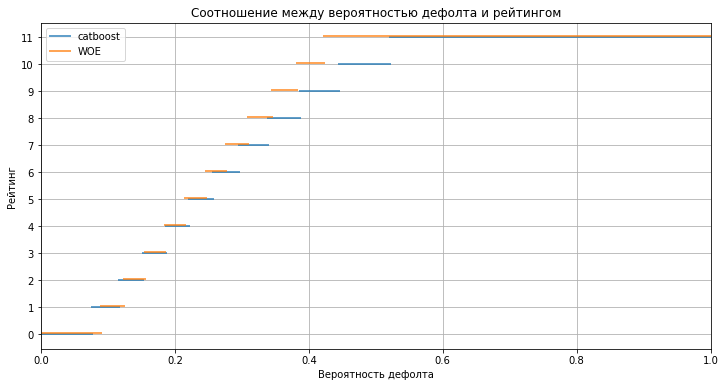

In [12]:
# NUM_RATINGS

# plt.scatter(catboost_ratings_info["train"]["score", "amin"], catboost_ratings_info["train"].index)
# plt.scatter(catboost_ratings_info["train"]["score", "amax"], catboost_ratings_info["train"].index)
plt.figure(figsize=(12, 6))
for i, a in catboost_ratings_info["train"].iterrows():
    if i == 0:
        xmin = 0
    else:
        xmin = a["score", "amin"]
    if i == NUM_RATINGS - 1:
        xmax = 1
    else:
        xmax = a["score", "amax"]
    line1 = plt.axhline(
        y=i,
        xmin=xmin,
        xmax=xmax,
        # color='b',
        alpha=0.7,
        label="catboost",
        # linewidth = 12,
        # linestyle='-.',
        color="C0",
        linewidth=2,
    )
for i, a in woe_ratings_info["train"].iterrows():
    if i == 0:
        xmin = 0
    else:
        xmin = a["score", "amin"]
    if i == NUM_RATINGS - 1:
        xmax = 1
    else:
        xmax = a["score", "amax"]
    line2 = plt.axhline(
        y=i + 0.05,
        xmin=xmin,
        xmax=xmax,
        # color='r',
        alpha=0.7,
        label="WOE",
        # linestyle='-.',
        color="C1",
        linewidth=2,
    )
plt.yticks(range(NUM_RATINGS))
plt.title("Соотношение между вероятностью дефолта и рейтингом")
plt.xlabel("Вероятность дефолта")
plt.ylabel("Рейтинг")
plt.grid()
plt.legend(handles=[line1, line2])
plt.show()

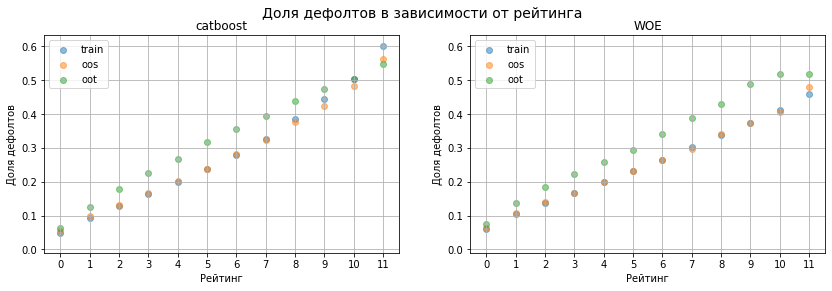

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
max_ylim = 0
for key in dfs_catboost:
    # plt.hist(dfs_catboost[key]["rating"], bins = NUM_RATINGS, alpha = 0.3, label = key)
    axs[0].scatter(catboost_ratings_info[key].index, catboost_ratings_info[key]["target", "mean"], alpha=0.5, label=key)

    axs[1].scatter(woe_ratings_info[key].index, woe_ratings_info[key]["target", "mean"], alpha=0.5, label=key)
    max_ylim = max(
        catboost_ratings_info[key]["target", "mean"].max(), woe_ratings_info[key]["target", "mean"].max(), max_ylim
    )

axs[0].set_title("catboost")
axs[1].set_title("WOE")

for ax in axs:
    ax.set_xticks(range(NUM_RATINGS))
    ax.legend()
    ax.grid()
    ax.set_ylim((-0.01, max_ylim * 1.05))
    ax.set_ylabel("Доля дефолтов")
    ax.set_xlabel("Рейтинг")

fig.suptitle("Доля дефолтов в зависимости от рейтинга", fontsize=14)
plt.show()

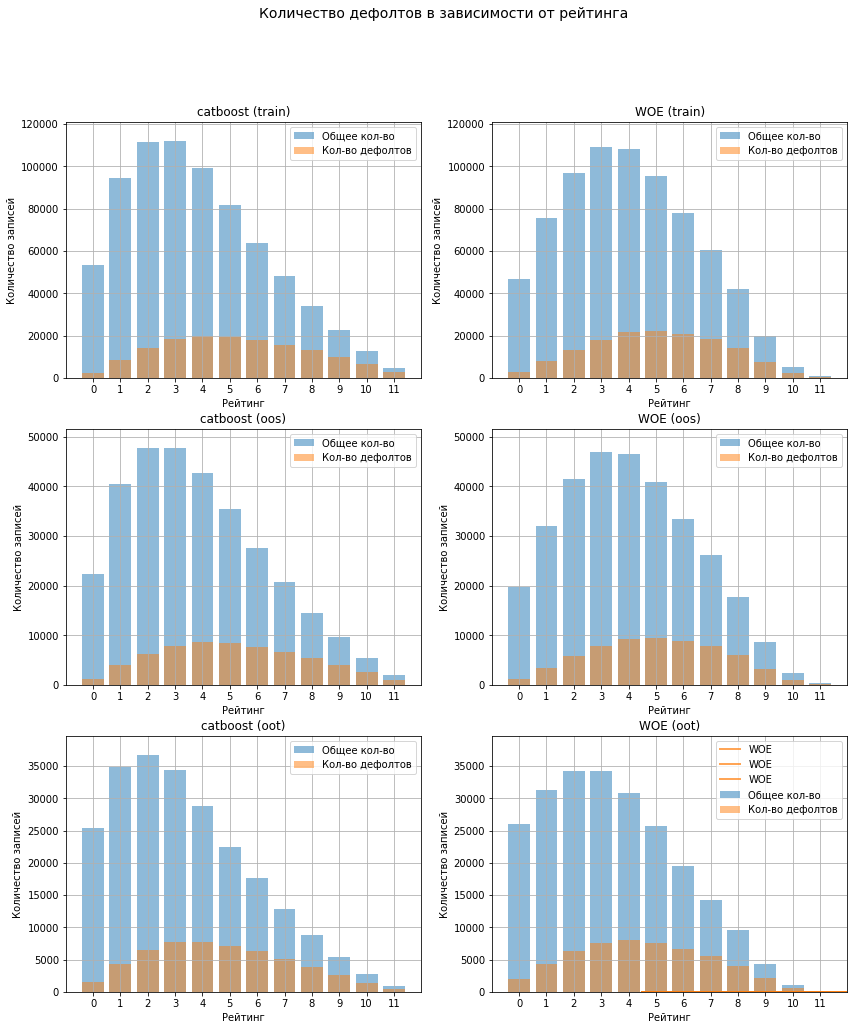

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(14, 16))
for i, key in enumerate(["train", "oos", "oot"]):
    # plt.hist(dfs_catboost[key]["rating"], bins = NUM_RATINGS, alpha = 0.3, label = key)
    axs[i, 0].bar(
        catboost_ratings_info[key].index, catboost_ratings_info[key]["target", "len"], alpha=0.5, label="Общее кол-во"
    )
    axs[i, 0].bar(
        catboost_ratings_info[key].index,
        catboost_ratings_info[key]["target", "sum"],
        alpha=0.5,
        label="Кол-во дефолтов",
    )

    axs[i, 1].bar(woe_ratings_info[key].index, woe_ratings_info[key]["target", "len"], alpha=0.5, label="Общее кол-во")
    axs[i, 1].bar(
        woe_ratings_info[key].index, woe_ratings_info[key]["target", "sum"], alpha=0.5, label="Кол-во дефолтов"
    )

    line2 = plt.axhline(
        y=i + 0.05,
        xmin=xmin,
        xmax=xmax,
        # color='r',
        alpha=0.7,
        label="WOE",
        # linestyle='-.',
        color="C1",
        linewidth=2,
    )

    axs[i, 0].set_title(f"catboost ({key})")
    axs[i, 1].set_title(f"WOE ({key})")

    for ax in axs[i]:
        ax.set_xticks(range(NUM_RATINGS))
        ax.legend()
        ax.grid()
        ax.set_ylim(
            (
                0,
                max(
                    catboost_ratings_info[key]["target", "len"].max() * 1.08,
                    woe_ratings_info[key]["target", "len"].max() * 1.08,
                ),
            )
        )
        ax.set_ylabel("Количество записей")
        ax.set_xlabel("Рейтинг")

fig.suptitle("Количество дефолтов в зависимости от рейтинга", fontsize=14)
plt.show()

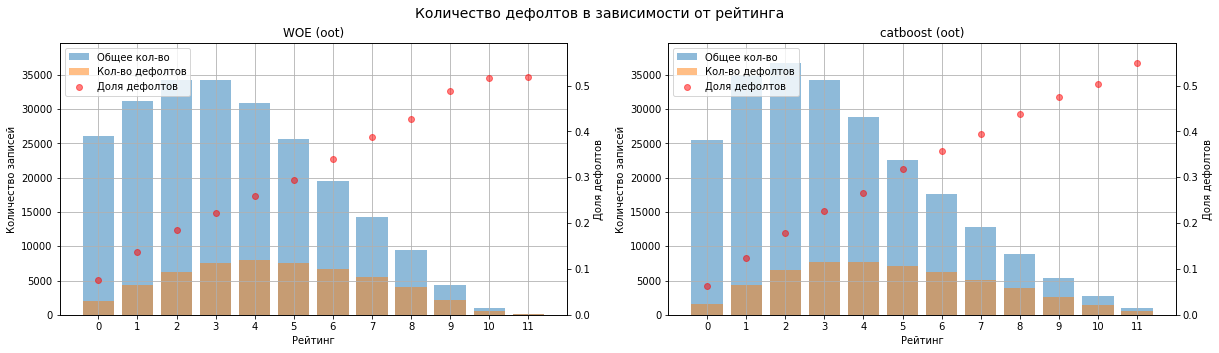

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
# for i,key in enumerate(["train", "oos", "oot"]):
# plt.hist(dfs_catboost[key]["rating"], bins = NUM_RATINGS, alpha = 0.3, label = key)

for dataset, title, ax in zip([woe_ratings_info, catboost_ratings_info], [f"WOE ({key})", f"catboost ({key})"], axs):
    key = "oot"
    labels = []
    labels.append(ax.bar(dataset[key].index, dataset[key]["target", "len"], alpha=0.5, label="Общее кол-во"))

    labels.append(ax.bar(dataset[key].index, dataset[key]["target", "sum"], alpha=0.5, label="Кол-во дефолтов"))

    ax2 = ax.twinx()
    labels.append(
        ax2.scatter(
            dataset[key].index,
            dataset[key]["target", "mean"],
            color="red",
            alpha=0.5,
            # marker = "*",
            label="Доля дефолтов",
        )
    )
    # delta = 0.01
    # for i, a in dataset[key].iterrows():
    #     ax2.axhline(y=a["target", "mean"],
    #                 xmin=i - delta, xmax=i + delta,
    #                     color='r',
    #                     alpha = 0.7,
    #                     label = "Доля дефолтов",
    #                     # linestyle='-.',
    #                     linewidth=2)

    ax.set_title(title)
    ax.set_xticks(range(NUM_RATINGS))
    ax.legend(handles=labels, loc=2)
    ax.grid()
    ax.set_ylim(
        (
            0,
            max(
                catboost_ratings_info[key]["target", "len"].max() * 1.08,
                woe_ratings_info[key]["target", "len"].max() * 1.08,
            ),
        )
    )
    ax2.set_ylim(
        (
            0,
            max(
                catboost_ratings_info[key]["target", "mean"].max() * 1.08,
                woe_ratings_info[key]["target", "mean"].max() * 1.08,
            ),
        )
    )
    ax.set_ylabel("Количество записей")
    ax2.set_ylabel("Доля дефолтов")
    ax.set_xlabel("Рейтинг")

fig.suptitle("Количество дефолтов в зависимости от рейтинга", fontsize=14)
plt.show()

/tmp/ipykernel_1621/2715971859.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_catboost[key]["round_issue_d"] = dfs_catboost[key]["issue_d"].round("1d")
/tmp/ipykernel_1621/2715971859.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_woe[key]["round_issue_d"] = dfs_woe[key]["issue_d"].round("1d")


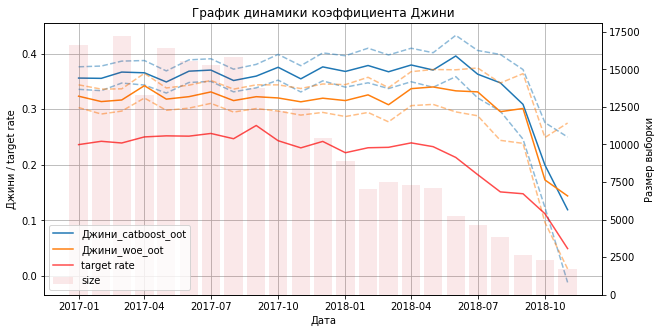

In [16]:
import numpy as np
import scipy.stats as ss
from sklearn.metrics import roc_auc_score


def gini_stats(data):
    alpha = 0.95
    target = data["target"]
    score = data["score"]
    conf = ss.norm.ppf(1 - (1 - alpha) / 2)
    roc_auc = roc_auc_score(target, score)
    gini = roc_auc * 2 - 1

    q1 = roc_auc / (2 - roc_auc)
    q2 = 2 * roc_auc ** 2 / (1 + roc_auc)
    positive = target.sum()
    negative = len(target) - positive
    sigma = roc_auc * (1 - roc_auc) + (positive - 1) * (q1 - roc_auc ** 2) + (negative - 1) * (q2 - roc_auc ** 2)
    sigma /= positive * negative
    gini_std = 2 * np.sqrt(sigma)

    return {
        "mu": gini,
        "std": gini_std,
        "lower_95": gini - conf * gini_std,
        "upper_95": gini + conf * gini_std,
        "size": data.shape[0],
        "target_rate": data["target"].mean(),
    }


# def agg_gini(data):
#      return (roc_auc_score(data["target"], data["score"]) - 0.5) * 2
key = "oot"

dfs_catboost[key]["round_issue_d"] = dfs_catboost[key]["issue_d"].round("1d")
dfs_woe[key]["round_issue_d"] = dfs_woe[key]["issue_d"].round("1d")

split_date_catboost = dfs_catboost[key].groupby("round_issue_d").apply(gini_stats)
split_date_woe = dfs_woe[key].groupby("round_issue_d").apply(gini_stats)

split_date_catboost = pd.DataFrame(split_date_catboost.tolist(), index=split_date_catboost.index)
split_date_woe = pd.DataFrame(split_date_woe.tolist(), index=split_date_woe.index)

fig, ax1 = plt.subplots(figsize=(10, 5))
labels = []
for dataset, color, label in zip([split_date_catboost, split_date_woe], ["C0", "C1"], ["catboost", "woe"]):
    labels.append(ax1.plot(dataset["mu"], label=f"Джини_{label}_{key}", color=color)[0])
    ax1.plot(dataset["lower_95"], label=f"catboost_{key}", color=color, linestyle="--", alpha=0.5)
    ax1.plot(dataset["upper_95"], label=f"catboost_{key}", color=color, linestyle="--", alpha=0.5)
labels.append(ax1.plot(dataset["target_rate"], label=f"target rate", color="red", linestyle="-", alpha=0.7)[0])
plt.grid()
ax2 = ax1.twinx()
labels.append(ax2.bar(dataset.index, dataset["size"], label=f"size", alpha=0.1, width=25, color="C3"))
# ax2.set_yscale("log")

ax1.set_ylabel("Джини / target rate")
ax2.set_ylabel("Размер выборки")
plt.title("График динамики коэффициента Джини")
plt.legend(handles=labels, loc=3)
ax1.set_xlabel("Дата")
plt.show();

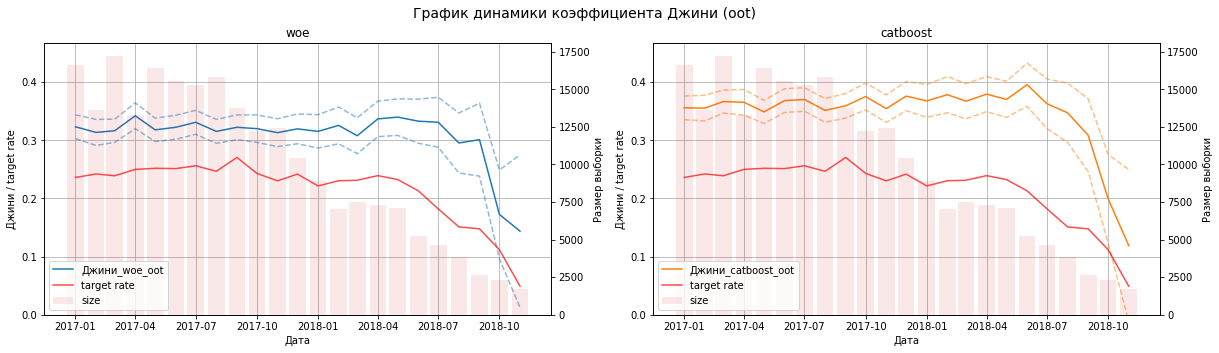

In [17]:
# def agg_gini(data):
#      return (roc_auc_score(data["target"], data["score"]) - 0.5) * 2

fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(20, 5))
labels = []
for dataset, color, label, ax1 in zip(
    [split_date_woe, split_date_catboost], ["C0", "C1"], ["woe", "catboost"], [ax_1, ax_2]
):
    labels = []
    labels.append(ax1.plot(dataset["mu"], label=f"Джини_{label}_{key}", color=color)[0])
    ax1.plot(dataset["lower_95"], label=f"catboost_{key}", color=color, linestyle="--", alpha=0.5)
    ax1.plot(dataset["upper_95"], label=f"catboost_{key}", color=color, linestyle="--", alpha=0.5)
    labels.append(ax1.plot(dataset["target_rate"], label=f"target rate", color="red", linestyle="-", alpha=0.7)[0])
    ax1.grid()
    ax2 = ax1.twinx()

    labels.append(ax2.bar(dataset.index, dataset["size"], label=f"size", alpha=0.1, width=25, color="C3"))
    # ax2.set_yscale("log")

    ax1.set_ylabel("Джини / target rate")
    ax2.set_ylabel("Размер выборки")
    plt.title(label)
    plt.legend(handles=labels, loc=3)
    ax1.set_xlabel("Дата")

    ax1.set_ylim((0, max(split_date_woe["upper_95"].max() * 1.08, split_date_catboost["upper_95"].max() * 1.08)))

fig.suptitle("График динамики коэффициента Джини (oot)", fontsize=14)
plt.show();

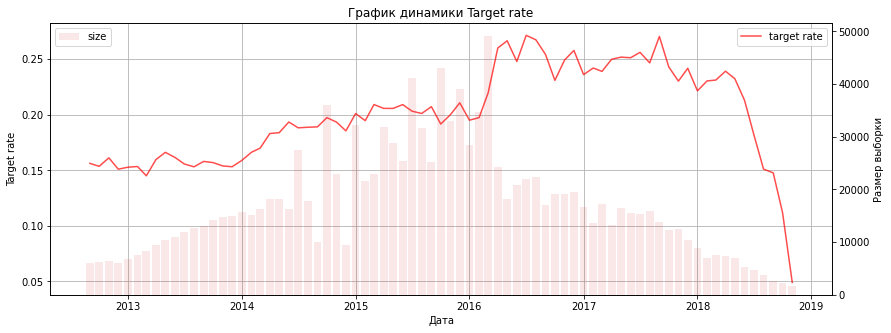

In [18]:
# def agg_gini(data):
#      return (roc_auc_score(data["target"], data["score"]) - 0.5) * 2
key = "oot"

all_data = pd.concat([dfs_catboost["train"], dfs_catboost["oos"], dfs_catboost["oot"]])

all_data["round_issue_d"] = all_data["issue_d"].round("1d")
split_date_all_data = all_data.groupby("round_issue_d").apply(gini_stats)
split_date_all_data = pd.DataFrame(split_date_all_data.tolist(), index=split_date_all_data.index)


fig, ax1 = plt.subplots(figsize=(14, 5))


ax1.plot(split_date_all_data["target_rate"], label=f"target rate", color="red", linestyle="-", alpha=0.7)
plt.grid()
ax2 = ax1.twinx()
ax2.bar(split_date_all_data.index, split_date_all_data["size"], label=f"size", alpha=0.1, width=25, color="C3")
# ax2.set_yscale("log")

ax1.set_ylabel("Target rate")
ax2.set_ylabel("Размер выборки")
plt.title("График динамики Target rate")
ax1.legend(loc=1)
ax2.legend(loc=2)
ax1.set_xlabel("Дата")
plt.show();

#  Относительное и абслютное отклонение

In [19]:
def gini_metric(target, score):
    roc_auc = roc_auc_score(target, score)
    return roc_auc * 2 - 1


def diff_metrics(df1, df2, metric_function):
    m1 = metric_function(df1["target"], df1["score"])
    m2 = metric_function(df2["target"], df2["score"])
    return {
        "Метрики Джини": "{:1.4f}/{:1.4f}".format(m1, m2),
        "Абс. откл.": "{:1.4f}".format(m1 - m2),
        "Отн. откл. (%)": "{:2.2f}".format((m1 - m2) / m1 * 100),
    }

In [20]:
metrics = []
metrics.append(diff_metrics(dfs_woe["train"], dfs_woe["oos"], gini_metric))
metrics.append(diff_metrics(dfs_woe["train"], dfs_woe["oot"], gini_metric))
metrics.append(diff_metrics(dfs_woe["oos"], dfs_woe["oot"], gini_metric))
pd.DataFrame(metrics, index=["train/oos", "train/oot", "oos/oot"])

,Метрики Джини,Абс. откл.,Отн. откл. (%)
train/oos,0.2883/0.2823,0.0060,2.06
train/oot,0.2883/0.3245,-0.0362,-12.55
oos/oot,0.2823/0.3245,-0.0421,-14.92


In [21]:
metrics = []
metrics.append(diff_metrics(dfs_catboost["train"], dfs_catboost["oos"], gini_metric))
metrics.append(diff_metrics(dfs_catboost["train"], dfs_catboost["oot"], gini_metric))
metrics.append(diff_metrics(dfs_catboost["oos"], dfs_catboost["oot"], gini_metric))
pd.DataFrame(metrics, index=["train/oos", "train/oot", "oos/oot"])

,Метрики Джини,Абс. откл.,Отн. откл. (%)
train/oos,0.3731/0.3533,0.0198,5.30
train/oot,0.3731/0.3643,0.0088,2.36
oos/oot,0.3533/0.3643,-0.0110,-3.10


In [22]:
# metrics = []
# metrics.append(diff_metrics(dfs_woe["train"], dfs_woe["oos"], roc_auc_score))
# metrics.append(diff_metrics(dfs_woe["train"], dfs_woe["oot"], roc_auc_score))
# metrics.append(diff_metrics(dfs_woe["oos"], dfs_woe["oot"], roc_auc_score))
# pd.DataFrame(metrics, index = ["train/oos", "train/oot", "oos/oot"])

In [23]:
# metrics = []
# metrics.append(diff_metrics(dfs_catboost["train"], dfs_catboost["oos"], roc_auc_score))
# metrics.append(diff_metrics(dfs_catboost["train"], dfs_catboost["oot"], roc_auc_score))
# metrics.append(diff_metrics(dfs_catboost["oos"], dfs_catboost["oot"], roc_auc_score))
# pd.DataFrame(metrics, index = ["train/oos", "train/oot", "oos/oot"])

# PSI

In [24]:
from psi import calculate_psi
from sklearn.preprocessing import LabelEncoder

In [25]:
features_catboost = [
    "home_ownership",
    "log_annual_inc",
    "annual_inc",
    "num_rev_tl_bal_gt_0",
    "mort_acc",
    "funded_amnt_inv",
    "emp_title",
    "bc_open_to_buy",
    "debt_load",
    "fico_range_low",
    "fico_range_high",
]
features_woe = [
    "fico_range_high",
    "debt_load",
    "bc_open_to_buy",
    "verification_status",
    "mort_acc",
    "total_bc_limit",
    "annual_inc",
    "num_rev_tl_bal_gt_0",
    "home_ownership",
    "purpose",
]

features = list(set(features_catboost + features_woe))

In [26]:
volume = 50000
psis = {}
psis["train/oos"] = {}
psis["train/oot"] = {}
psis["oos/oot"] = {}
for feature in features:
    if feature in dfs_catboost["train"].columns:
        train = dfs_catboost["train"][feature].sample(volume)  # .fillna(-1)
        oos = dfs_catboost["oos"][feature].sample(volume)  # .fillna(-1)
        oot = dfs_catboost["oot"][feature].sample(volume)  # .fillna(-1)
        buckets = int(volume / 1000)

        if feature in ["home_ownership", "emp_title", "verification_status", "purpose"]:
            le = LabelEncoder()
            le.fit(pd.concat([train, oos, oot]))
            buckets = pd.concat([train, oos, oot]).nunique()
            train = le.transform(train)
            oos = le.transform(oos)
            oot = le.transform(oot)

        # try:
        psis["train/oos"][feature] = round(
            calculate_psi(train, oos, buckettype="quantiles", buckets=buckets, axis=1), 4
        )
        psis["train/oot"][feature] = round(
            calculate_psi(train, oot, buckettype="quantiles", buckets=buckets, axis=1), 4
        )
        psis["oos/oot"][feature] = round(calculate_psi(oos, oot, buckettype="quantiles", buckets=buckets, axis=1), 4)
        # except:
        #     print(feature)

/home/asciishell/project/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [27]:
psi_result = pd.DataFrame()
for datas in psis:
    psi_result[datas] = pd.Series(psis[datas])
psi_result.sort_values("oos/oot", ascending=False)

,train/oos,train/oot,oos/oot
funded_amnt_inv,0.0019,0.0856,0.0840
debt_load,0.0012,0.0778,0.0789
fico_range_low,0.0005,0.0541,0.0565
fico_range_high,0.0010,0.0518,0.0548
purpose,0.0001,0.0383,0.0367
total_bc_limit,0.0018,0.0265,0.0257
emp_title,0.0012,0.0152,0.0172
mort_acc,0.0005,0.0172,0.0165
verification_status,0.0000,0.0155,0.0159
log_annual_inc,0.0018,0.0105,0.0105


In [28]:
volume = 50000
psis = {}
psis["train/oos"] = {}
psis["train/oot"] = {}
psis["oos/oot"] = {}
feature = "score"

for dataset, label in zip([dfs_woe, dfs_catboost], ["woe", "catboost"]):
    train = dataset["train"][feature].sample(volume)  # .fillna(-1)
    oos = dataset["oos"][feature].sample(volume)  # .fillna(-1)
    oot = dataset["oot"][feature].sample(volume)  # .fillna(-1)
    buckets = int(volume / 1000)

    # try:
    psis["train/oos"][f"{label}_{feature}"] = round(
        calculate_psi(train, oos, buckettype="quantiles", buckets=buckets, axis=1), 4
    )
    psis["train/oot"][f"{label}_{feature}"] = round(
        calculate_psi(train, oot, buckettype="quantiles", buckets=buckets, axis=1), 4
    )
    psis["oos/oot"][f"{label}_{feature}"] = round(
        calculate_psi(oos, oot, buckettype="quantiles", buckets=buckets, axis=1), 4
    )
    # except:
    #     print(feature)

In [29]:
psi_result = pd.DataFrame()
for datas in psis:
    psi_result[datas] = pd.Series(psis[datas])
psi_result.sort_values("oos/oot", ascending=False)

,train/oos,train/oot,oos/oot
woe_score,0.0015,0.0707,0.0711
catboost_score,0.0019,0.0366,0.0371
